# Interval tests

**genomeinterv** implements tests for a significant relationship between sets of intervals.

In [1]:
#| echo: false
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'svg'

## Proximity

[](`~genominterv.stats.proximity_test`) computes tests if intervals in one set is significantly
proximal to intervals in another set.

In [2]:
annot = pd.DataFrame(dict(chrom='chr1', 
                          start=[38_000_000, 100_000_000, 175_000_000], 
                          end=[40_000_000, 103_000_000, 178_000_000]))
query = pd.DataFrame(dict(chrom='chr1', 
                          start=[41_000_000, 105_000_000, 170_000_000], 
                          end=[40_500_000, 106_000_000, 173_000_000]))

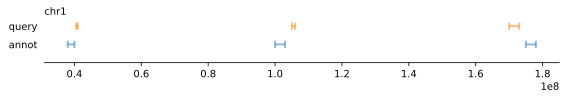

In [3]:
#| echo: false
#| label: fig-proximity
#| fig-cap: "Intervals"
from genominterv.intervals import _plot_intervals
_plot_intervals(annot=annot, query=query)

With the `multiprocess` library installed:

    conda install conda-forge::multiprocess

you can run the permutation test on all the cores you have:    

In [6]:
from genominterv.stats import proximity_test

stat, pvalue = proximity_test(query, annot, cores=8)
pvalue

0.0

## Overlap

[](`~genominterv.stats.jaccard_stat`) computes the [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index)
statistic for two sets of genomic intervals.


This can be combined with the [](`~genominterv.decorators.bootstrap`) decorator to produce a test for overlap. The decorator turns a function producing
a statistic into one that also produces a p-value. The bootstrapping resamples
the intervals of the second argument for each chromosome independently. Only
required argument to bootstrap is the name of the chromosome assembly used.

In [5]:
annot = pd.DataFrame(dict(chrom='chr1', 
                          start=[18_000_000, 58_000_000, 138_000_000], 
                          end=[20_000_000, 60_000_000, 140_000_000]))
query = pd.DataFrame(dict(chrom='chr1', 
                          start=[41_000_000, 59_000_000, 241_000_000], 
                          end=[40_500_000, 61_000_000, 241_000_000]))

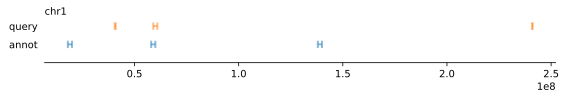

In [6]:
#| echo: false
#| label: fig-overlap
#| fig-cap: "Intervals"
from genominterv.intervals import _plot_intervals
_plot_intervals(annot=annot, query=query)

With the `multiprocess` library installed:

    conda install conda-forge::multiprocess

you can run the bootstrapping on all the cores you have:    

In [7]:
from genominterv.decorators import bootstrap
from genominterv.stats import jaccard_stat

@bootstrap('hg19', cores=8)
def jaccard_test(q, a):
    return jaccard_stat(q, a)

stat, p_value = jaccard_test(query, annot)
stat, p_value 

(0.0, 0.96778)

In [8]:
from genominterv.intervals import interval_diff

non_ovl_query = interval_diff(query, annot)
non_ovl_query

,start,end,chrom
0,41000000,40500000,chr1
1,105000000,106000000,chr1
2,170000000,173000000,chr1


In [10]:
import seaborn as sns
from genominterv.intervals import interval_diff

records = []
for overlap_as_zero in [False, True]:
    for span_as_zero in [False, True]:
        n = 1000
        a = np.sort(np.random.randint(1, 10_000_000, size=n))
        annot = pd.DataFrame(dict(chrom='chrX', start=a, end=a+10))
        q = np.sort(np.random.randint(1, 10_000_000, size=n))
        query = pd.DataFrame(dict(chrom='chrX', start=q, end=q+10))
        non_ovl_query = interval_diff(query, annot)
        records.append(('random', 'full', overlap_as_zero, span_as_zero, *proximity_test(
            query, annot, overlap_as_zero=overlap_as_zero, span_as_zero=span_as_zero, cores=8)))
        records.append(('random', 'nonovl', overlap_as_zero, span_as_zero, *proximity_test(
            non_ovl_query, annot, overlap_as_zero=overlap_as_zero, span_as_zero=span_as_zero, cores=8)))
        
        a = np.sort(np.random.randint(1, 10_000_000, size=n))
        annot = pd.DataFrame(dict(chrom='chrX', start=a, end=a+10))
        q = a + np.random.randint(-1000, 1000, size=n)
        query = pd.DataFrame(dict(chrom='chrX', start=q, end=q+10))
        non_ovl_query = interval_diff(query, annot)
        records.append(('non-random', 'full', overlap_as_zero, span_as_zero, *proximity_test(
            query, annot, overlap_as_zero=overlap_as_zero, span_as_zero=span_as_zero, cores=8)))
        records.append(('non-random', 'non-ovl', overlap_as_zero, span_as_zero, *proximity_test(
            non_ovl_query, annot, overlap_as_zero=overlap_as_zero, span_as_zero=span_as_zero, cores=8)))
        
df = pd.DataFrame().from_records(records, columns=['query', 'subset', 'overlap_as_zero', 'span_as_zero', 'stat', 'p'])
df['-log10p'] = -np.log10(df.p)
df

/Users/kmt/miniconda3/envs/condabuild/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,query,subset,overlap_as_zero,span_as_zero,stat,p,-log10p
0,random,full,False,False,0.017866,0.2050,0.688246
1,random,nonovl,False,False,0.019826,0.1259,0.899974
2,non-random,full,False,False,0.610130,0.0000,inf
3,non-random,non-ovl,False,False,0.616401,0.0000,inf
4,random,full,False,True,0.032529,0.0000,inf
5,random,nonovl,False,True,0.033496,0.0000,inf
6,non-random,full,False,True,0.572356,0.0000,inf
7,non-random,non-ovl,False,True,0.576616,0.0000,inf
8,random,full,True,False,0.006355,0.8847,0.053204
9,random,nonovl,True,False,0.006355,0.8847,0.053204


In [11]:
df.loc[df.span_as_zero == False].sort_values(by='query')

,query,subset,overlap_as_zero,span_as_zero,stat,p,-log10p
2,non-random,full,False,False,0.610130,0.0000,inf
3,non-random,non-ovl,False,False,0.616401,0.0000,inf
10,non-random,full,True,False,0.614519,0.0000,inf
11,non-random,non-ovl,True,False,0.614519,0.0000,inf
0,random,full,False,False,0.017866,0.2050,0.688246
1,random,nonovl,False,False,0.019826,0.1259,0.899974
8,random,full,True,False,0.006355,0.8847,0.053204
9,random,nonovl,True,False,0.006355,0.8847,0.053204


In [12]:
(df.style
 .background_gradient(subset='p', cmap='Reds', vmin=0, vmax=1)
 .background_gradient(subset='stat', cmap='Blues')
)


,query,subset,overlap_as_zero,span_as_zero,stat,p,-log10p
0,random,full,False,False,0.017866,0.205000,0.688246
1,random,nonovl,False,False,0.019826,0.125900,0.899974
2,non-random,full,False,False,0.610130,0.000000,inf
3,non-random,non-ovl,False,False,0.616401,0.000000,inf
4,random,full,False,True,0.032529,0.000000,inf
5,random,nonovl,False,True,0.033496,0.000000,inf
6,non-random,full,False,True,0.572356,0.000000,inf
7,non-random,non-ovl,False,True,0.576616,0.000000,inf
8,random,full,True,False,0.006355,0.884700,0.053204
9,random,nonovl,True,False,0.006355,0.884700,0.053204


In [17]:
def condition(v):
    if v == False:
        return "Dry"
    else:
        return "Rain"
    
def make_pretty(styler):
    # styler.set_caption("Weather Conditions")
    # styler.format(condition)
    # styler.format_index(lambda v: v.strftime("%A"))
    styler.background_gradient(axis=None, vmin=0, vmax=3, cmap="Reds")
    return styler

In [19]:
s = df.loc[df.span_as_zero == False].sort_values(by='query').style.pipe(make_pretty)
# s = df.style.pipe(make_pretty)
s

,query,subset,overlap_as_zero,span_as_zero,stat,p,-log10p
2,non-random,full,False,False,0.599101,0.000000,inf
3,non-random,non-ovl,False,False,0.603118,0.000000,inf
10,non-random,full,True,False,0.574230,0.000000,inf
11,non-random,non-ovl,True,False,0.574230,0.000000,inf
0,random,full,False,False,0.020704,0.125000,0.903090
1,random,nonovl,False,False,0.023642,0.000500,3.301030
8,random,full,True,False,0.021538,0.000200,3.698970
9,random,nonovl,True,False,0.021538,0.095600,1.019542


In [65]:
def highlight_max(s, props=''):
    return np.where(s == False, props, '')
s.apply(highlight_max, props='color:white;background-color:darkblue', axis=0)

,query,subset,overlap_as_zero,span_as_zero,stat,p,-log10p
0,random,full,False,False,-0.020317,1.000000,-0.000000
1,random,nonovl,False,False,-0.019295,0.374400,0.426664
2,random,full,False,False,0.616193,0.000000,inf
3,random,non-ovl,False,False,0.621944,0.000000,inf
4,random,full,False,True,-0.003482,0.296100,0.528562
5,random,nonovl,False,True,-0.002480,0.679800,0.167619
6,random,full,False,True,0.610937,0.000000,inf
7,random,non-ovl,False,True,0.613264,0.000000,inf
8,random,full,True,False,0.007992,0.039300,1.405607
9,random,nonovl,True,False,0.007992,0.251900,0.598772


In [ ]:
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')
s2.apply(highlight_max, props='color:white;background-color:darkblue', axis=0)